## Download and Visualize Data

In [1]:
# !wget https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip
# !mkdir emojis
# !unzip -q openmoji-72x72-color.zip -d ./emojis
# !pip install -q tensorflow==2.4

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.10.1


In [3]:
os.chdir('C:/Users/micha/OneDrive/Documents/JupyterProjects/Personal Project/Object Localization')
os.getcwd()

'C:\\Users\\micha\\OneDrive\\Documents\\JupyterProjects\\Personal Project\\Object Localization'

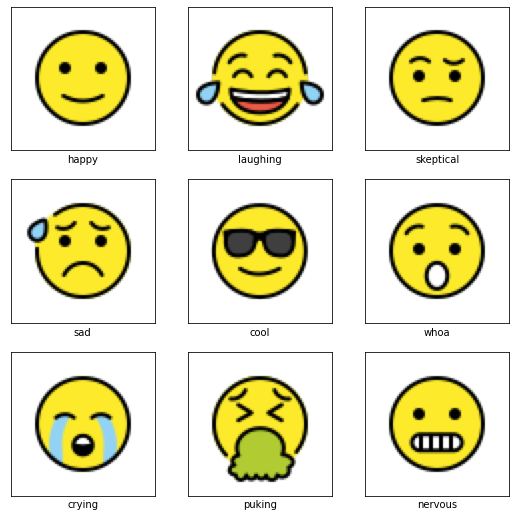

In [4]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Create Examples

In [5]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [6]:
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x154D8223AC0>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x154D8223A90>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x154D8223B50>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x154D82239A0>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x154D8223EE0>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x154D8223FA0>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x154CA3B6F10>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x154D8223CA0>},
 8: {'name': 'nervous',
  'file': '1F62C.pn

In [7]:
def create_example():
    class_id = np.random.randint(0, 9)
    image = np.ones((144, 144, 3)) * 255
    row = np.random.randint(0, 72)
    col = np.random.randint(0, 72)
    image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
    return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144

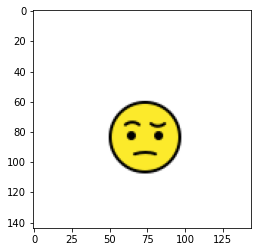

In [8]:
image, class_id, row, col = create_example()
plt.imshow(image);

## Plot Bounding Boxes

In [9]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
    if norm:
        image *= 255.
        image = image.astype('uint8')
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)

    row, col = gt_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col + 52, row + 52), outline='green', width=3)

    if len(pred_coords) == 2:
        row, col = pred_coords
        row *= 144
        col *= 144
        draw.rectangle((col, row, col + 52, row + 52), outline='red', width=3)
    return image

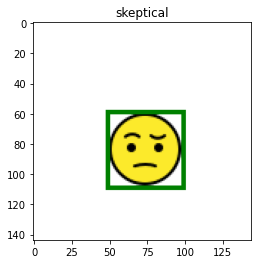

In [10]:
image = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Data Generator

In [11]:
def data_generator(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, 144, 144, 3))
        y_batch = np.zeros((batch_size, 9))
        bbox_batch = np.zeros((batch_size, 2))

        for i in range(0, batch_size):
            image, class_id, row, col = create_example()
            x_batch[i] = image / 255.
            y_batch[i, class_id] = 1.0
            bbox_batch[i] = np.array([row, col])
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}

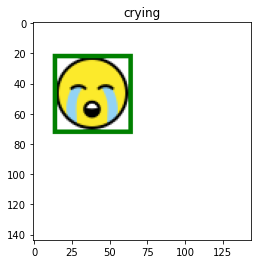

In [12]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Model

In [13]:
input_ = Input(shape=(144, 144, 3), name='image')

x = input_

for i in range(0, 5):
    n_filters = 2**(4 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(9, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 142, 142, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 142, 142, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Custom Metric: IoU

In [14]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)

        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
  
    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows * 144, cols * 144
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            return x1, y1, x2, y2
    
        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)

        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)

        i_area = get_area(i_x1, i_y1, i_x2, i_y2)
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

        iou = tf.math.divide(i_area, u_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
  
    def result(self):
        return self.iou
  
    def reset_state(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

## Compile the Model

In [15]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out': 'accuracy',
        'box_out': IoU(name='iou')
    }
)

## Custom Callback: Model Testing

In [16]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']

    pred_y, pred_box = model.predict(x)

    pred_coords = pred_box[0]
    gt_coords = box[0]
    pred_class = np.argmax(pred_y[0])
    image = x[0]

    gt = emojis[np.argmax(y[0])]['name']
    pred_class_name = emojis[pred_class]['name']

    image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
    color = 'green' if gt == pred_class_name else 'red'

    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])

In [17]:
def test(model):
    test_datagen = data_generator(1)
    plt.figure(figsize=(16, 4))

    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
    plt.show()

1/1 [==============================] - 0s 21ms/step


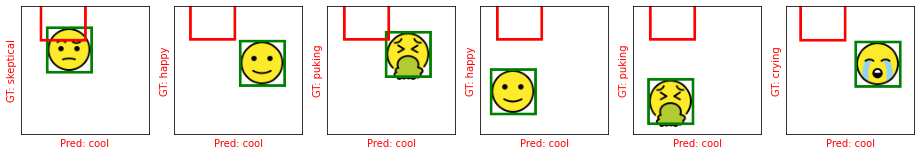

In [18]:
test(model)

In [19]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

## Model Training

Epoch 1/50
1/1 [==============================] - 0s 27ms/step


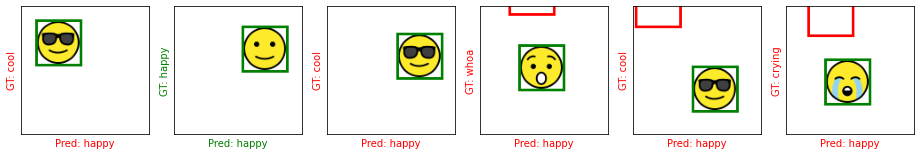

500/500 [==============================] - 12s 17ms/step - loss: 1.0294 - class_out_loss: 0.7475 - box_out_loss: 0.2819 - class_out_accuracy: 0.7504 - box_out_iou: 0.1008 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 0s 22ms/step


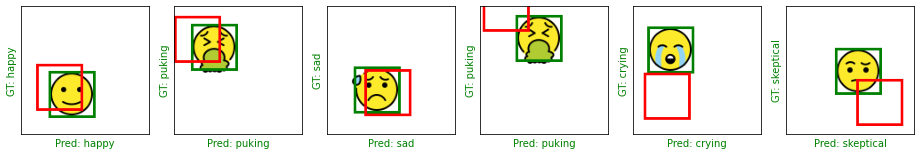

500/500 [==============================] - 9s 17ms/step - loss: 0.0409 - class_out_loss: 0.0105 - box_out_loss: 0.0304 - class_out_accuracy: 0.9996 - box_out_iou: 0.2039 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 23ms/step


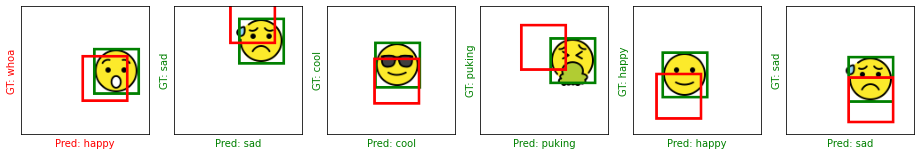

500/500 [==============================] - 8s 17ms/step - loss: 0.0182 - class_out_loss: 0.0040 - box_out_loss: 0.0142 - class_out_accuracy: 0.9999 - box_out_iou: 0.2732 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 0s 27ms/step


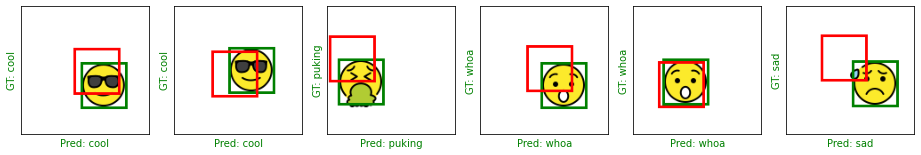

500/500 [==============================] - 8s 17ms/step - loss: 0.0105 - class_out_loss: 0.0018 - box_out_loss: 0.0087 - class_out_accuracy: 1.0000 - box_out_iou: 0.3283 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 0s 26ms/step


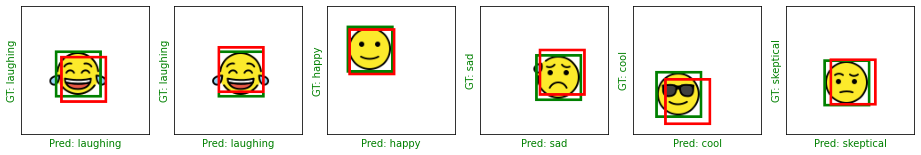

500/500 [==============================] - 9s 18ms/step - loss: 0.0043 - class_out_loss: 9.8901e-04 - box_out_loss: 0.0033 - class_out_accuracy: 1.0000 - box_out_iou: 0.3895 - lr: 2.0000e-04
Epoch 6/50
1/1 [==============================] - 0s 22ms/step


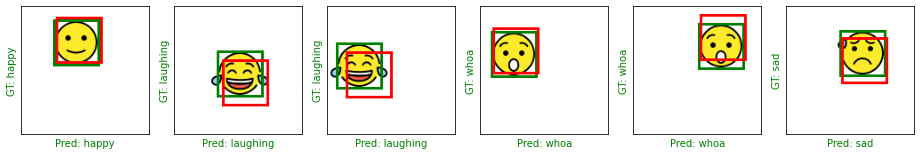

500/500 [==============================] - 9s 18ms/step - loss: 0.0035 - class_out_loss: 8.0282e-04 - box_out_loss: 0.0027 - class_out_accuracy: 1.0000 - box_out_iou: 0.4343 - lr: 2.0000e-04
Epoch 7/50
1/1 [==============================] - 0s 23ms/step


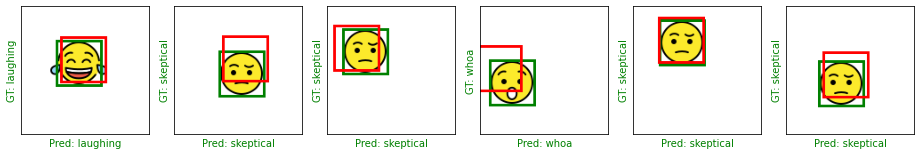

500/500 [==============================] - 8s 17ms/step - loss: 0.0031 - class_out_loss: 5.8540e-04 - box_out_loss: 0.0025 - class_out_accuracy: 1.0000 - box_out_iou: 0.4681 - lr: 2.0000e-04
Epoch 8/50
1/1 [==============================] - 0s 25ms/step


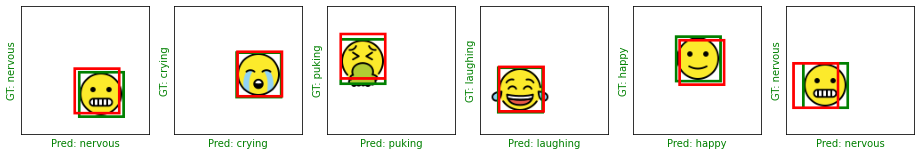

500/500 [==============================] - 8s 17ms/step - loss: 0.0029 - class_out_loss: 5.1786e-04 - box_out_loss: 0.0024 - class_out_accuracy: 1.0000 - box_out_iou: 0.4944 - lr: 2.0000e-04
Epoch 9/50
1/1 [==============================] - 0s 26ms/step


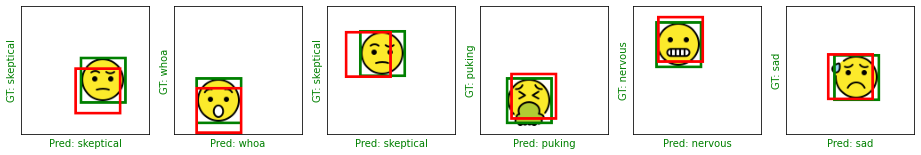

500/500 [==============================] - 8s 17ms/step - loss: 0.0030 - class_out_loss: 4.9203e-04 - box_out_loss: 0.0025 - class_out_accuracy: 1.0000 - box_out_iou: 0.5141 - lr: 2.0000e-04
Epoch 10/50
1/1 [==============================] - 0s 22ms/step


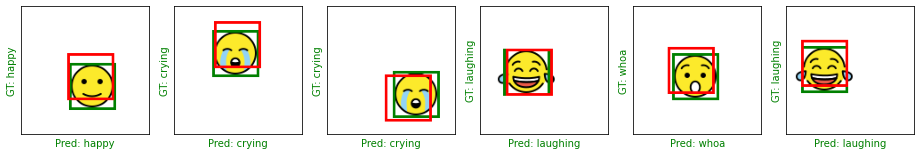

500/500 [==============================] - 8s 16ms/step - loss: 0.0021 - class_out_loss: 5.0173e-04 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - box_out_iou: 0.5348 - lr: 4.0000e-05
Epoch 11/50
1/1 [==============================] - 0s 28ms/step


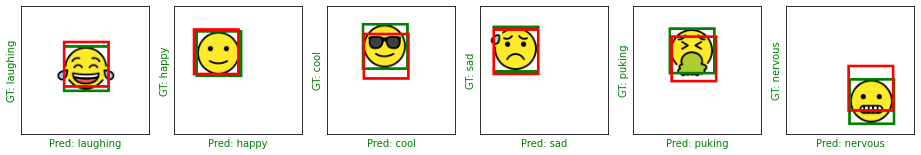

500/500 [==============================] - 9s 18ms/step - loss: 0.0019 - class_out_loss: 4.1323e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.5525 - lr: 4.0000e-05
Epoch 12/50
1/1 [==============================] - 0s 22ms/step


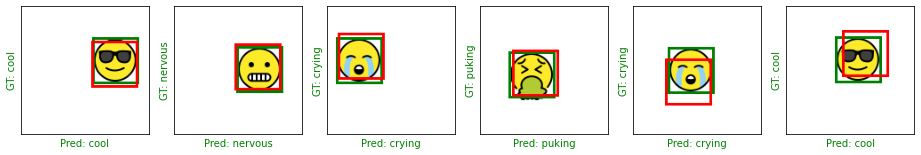

500/500 [==============================] - 9s 19ms/step - loss: 0.0019 - class_out_loss: 3.5475e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.5673 - lr: 4.0000e-05
Epoch 13/50
1/1 [==============================] - 0s 24ms/step


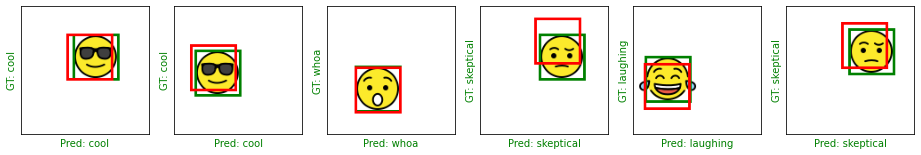

500/500 [==============================] - 11s 23ms/step - loss: 0.0019 - class_out_loss: 4.4524e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.5800 - lr: 4.0000e-05
Epoch 14/50
1/1 [==============================] - 0s 22ms/step


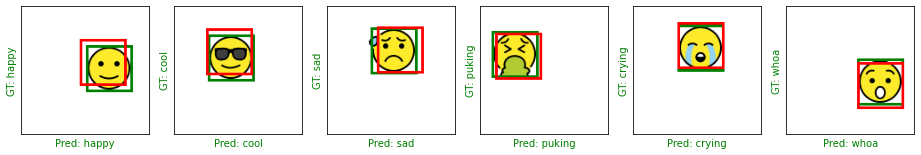

500/500 [==============================] - 10s 20ms/step - loss: 0.0018 - class_out_loss: 3.2704e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.5907 - lr: 4.0000e-05
Epoch 15/50
1/1 [==============================] - 0s 25ms/step


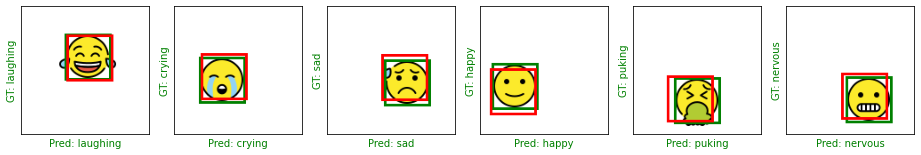

500/500 [==============================] - 10s 19ms/step - loss: 0.0016 - class_out_loss: 3.6550e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.6015 - lr: 8.0000e-06
Epoch 16/50
1/1 [==============================] - 0s 28ms/step


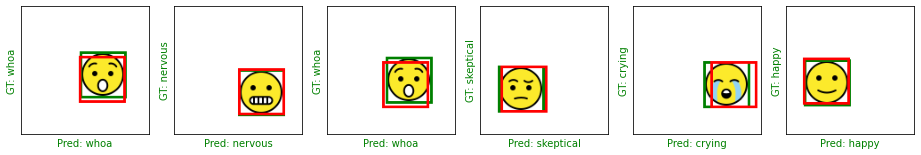

500/500 [==============================] - 11s 22ms/step - loss: 0.0015 - class_out_loss: 2.9384e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.6110 - lr: 8.0000e-06
Epoch 17/50
1/1 [==============================] - 0s 25ms/step


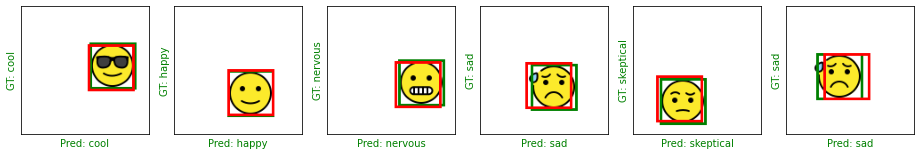

500/500 [==============================] - 11s 22ms/step - loss: 0.0016 - class_out_loss: 3.6104e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.6194 - lr: 8.0000e-06
Epoch 18/50
1/1 [==============================] - 0s 25ms/step


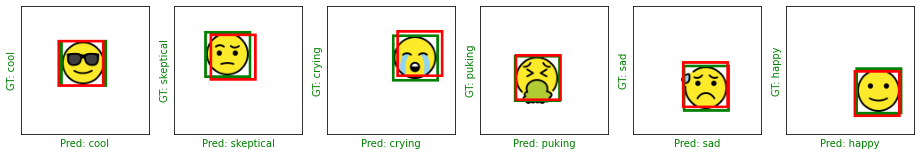

500/500 [==============================] - 10s 20ms/step - loss: 0.0015 - class_out_loss: 2.7843e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.6271 - lr: 8.0000e-06
Epoch 19/50
1/1 [==============================] - 0s 22ms/step


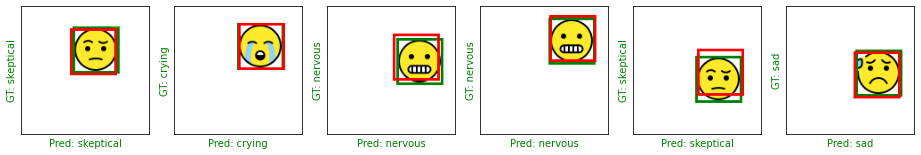

500/500 [==============================] - 10s 19ms/step - loss: 0.0014 - class_out_loss: 2.5832e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.6339 - lr: 8.0000e-06
Epoch 20/50
1/1 [==============================] - 0s 22ms/step


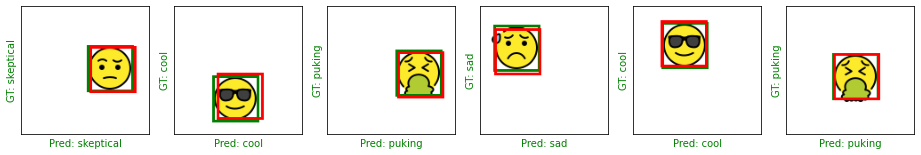

500/500 [==============================] - 10s 19ms/step - loss: 0.0013 - class_out_loss: 2.4716e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6404 - lr: 1.6000e-06
Epoch 21/50
1/1 [==============================] - 0s 24ms/step


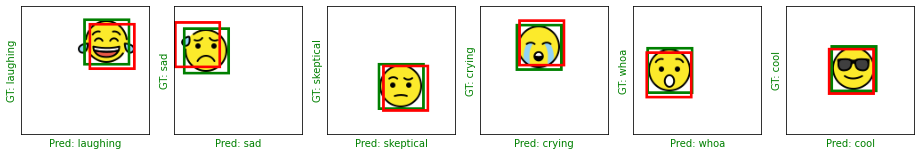

500/500 [==============================] - 10s 20ms/step - loss: 0.0014 - class_out_loss: 2.6983e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6461 - lr: 1.6000e-06
Epoch 22/50
1/1 [==============================] - 0s 28ms/step


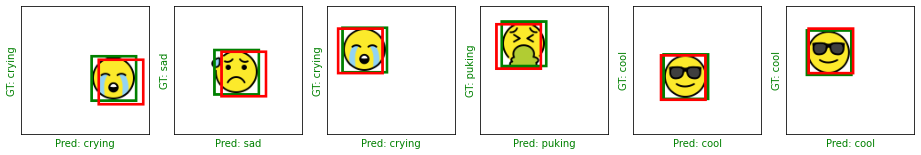

500/500 [==============================] - 10s 20ms/step - loss: 0.0014 - class_out_loss: 2.6862e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6515 - lr: 1.6000e-06
Epoch 23/50
1/1 [==============================] - 0s 26ms/step


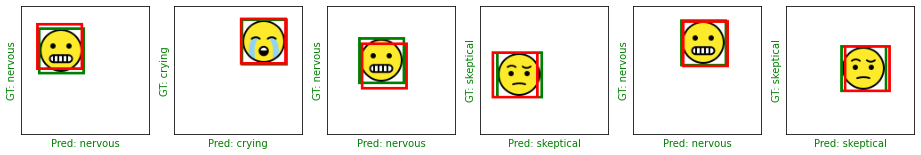

500/500 [==============================] - 10s 20ms/step - loss: 0.0013 - class_out_loss: 2.6491e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6565 - lr: 1.6000e-06
Epoch 24/50
1/1 [==============================] - 0s 26ms/step


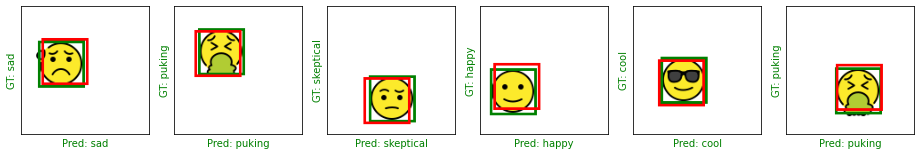

500/500 [==============================] - 10s 21ms/step - loss: 0.0013 - class_out_loss: 2.2386e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6611 - lr: 1.6000e-06
Epoch 25/50
1/1 [==============================] - 0s 25ms/step


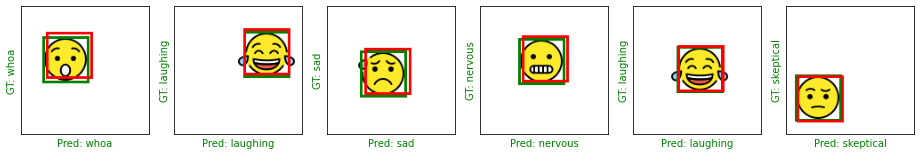

500/500 [==============================] - 10s 20ms/step - loss: 0.0014 - class_out_loss: 3.1366e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6653 - lr: 3.2000e-07
Epoch 26/50
1/1 [==============================] - 0s 27ms/step


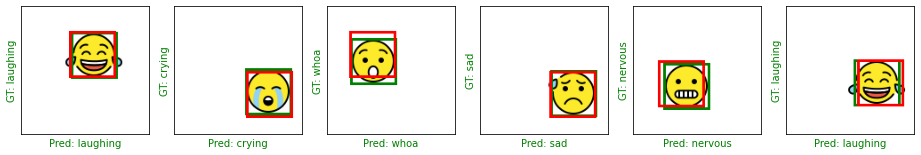

500/500 [==============================] - 9s 19ms/step - loss: 0.0013 - class_out_loss: 2.7969e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6692 - lr: 3.2000e-07
Epoch 27/50
1/1 [==============================] - 0s 24ms/step


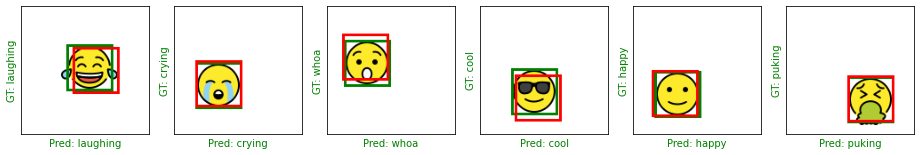

500/500 [==============================] - 9s 18ms/step - loss: 0.0014 - class_out_loss: 2.8683e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6728 - lr: 3.2000e-07
Epoch 28/50
1/1 [==============================] - 0s 23ms/step


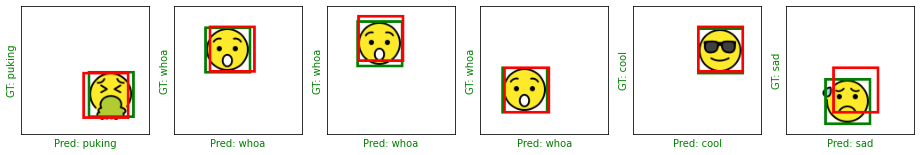

500/500 [==============================] - 9s 18ms/step - loss: 0.0013 - class_out_loss: 2.6401e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6761 - lr: 3.2000e-07
Epoch 29/50
1/1 [==============================] - 0s 21ms/step


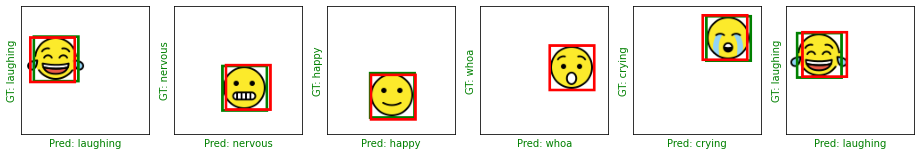

500/500 [==============================] - 9s 18ms/step - loss: 0.0013 - class_out_loss: 2.8119e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6793 - lr: 3.2000e-07
Epoch 30/50
1/1 [==============================] - 0s 21ms/step


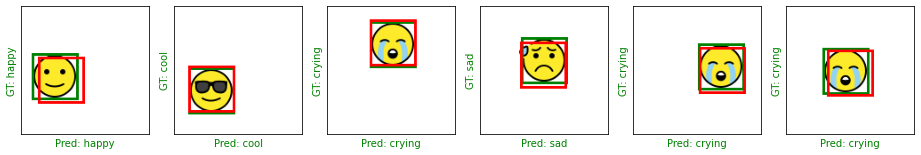

500/500 [==============================] - 9s 18ms/step - loss: 0.0014 - class_out_loss: 3.1179e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6822 - lr: 3.0000e-07
Epoch 31/50
1/1 [==============================] - 0s 21ms/step


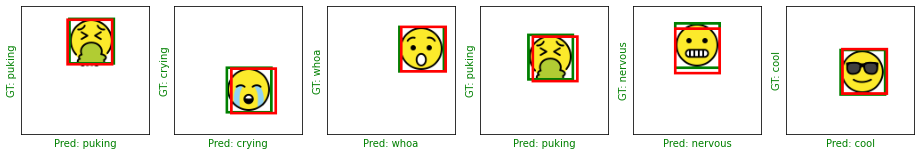

500/500 [==============================] - 9s 18ms/step - loss: 0.0012 - class_out_loss: 2.1995e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.6850 - lr: 3.0000e-07
Epoch 32/50
1/1 [==============================] - 0s 21ms/step


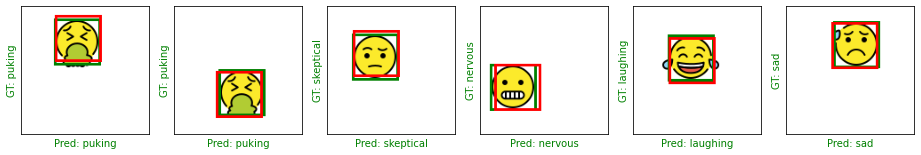

500/500 [==============================] - 9s 18ms/step - loss: 0.0013 - class_out_loss: 2.7918e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6875 - lr: 3.0000e-07
Epoch 33/50
1/1 [==============================] - 0s 25ms/step


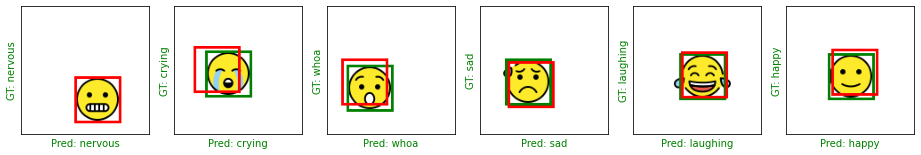

500/500 [==============================] - 9s 18ms/step - loss: 0.0013 - class_out_loss: 2.7569e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6900 - lr: 3.0000e-07
Epoch 34/50
1/1 [==============================] - 0s 24ms/step


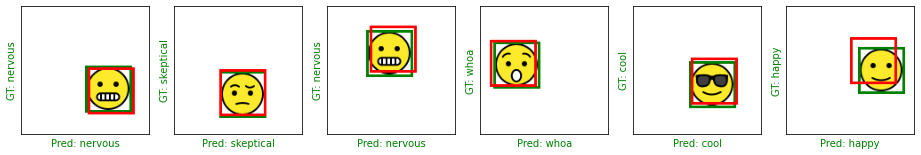

500/500 [==============================] - 9s 19ms/step - loss: 0.0013 - class_out_loss: 2.8044e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.6923 - lr: 3.0000e-07
Epoch 35/50
1/1 [==============================] - 0s 21ms/step


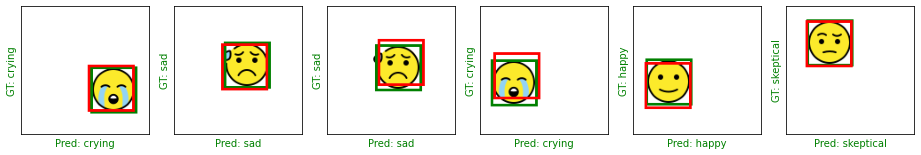

500/500 [==============================] - 9s 18ms/step - loss: 0.0013 - class_out_loss: 2.6471e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.6945 - lr: 3.0000e-07
Epoch 36/50
1/1 [==============================] - 0s 23ms/step


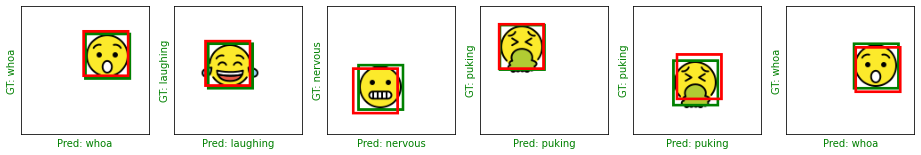

500/500 [==============================] - 9s 19ms/step - loss: 0.0013 - class_out_loss: 3.1150e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.6966 - lr: 3.0000e-07
Epoch 37/50
1/1 [==============================] - 0s 21ms/step


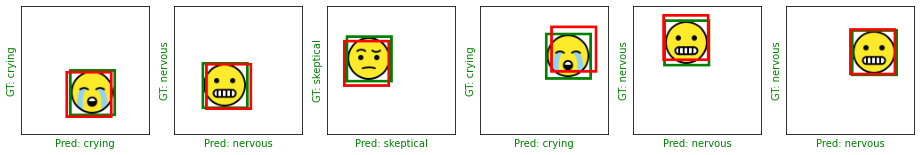

500/500 [==============================] - 9s 18ms/step - loss: 0.0014 - class_out_loss: 2.9552e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.6985 - lr: 3.0000e-07
Epoch 38/50
1/1 [==============================] - 0s 22ms/step


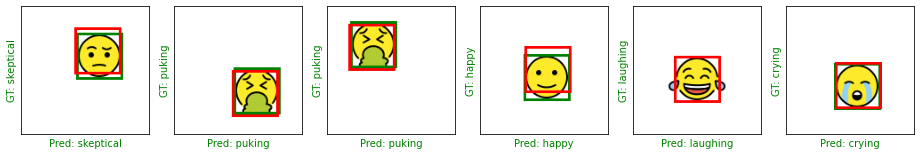

500/500 [==============================] - 9s 19ms/step - loss: 0.0014 - class_out_loss: 3.0124e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7003 - lr: 3.0000e-07
Epoch 39/50
1/1 [==============================] - 0s 22ms/step


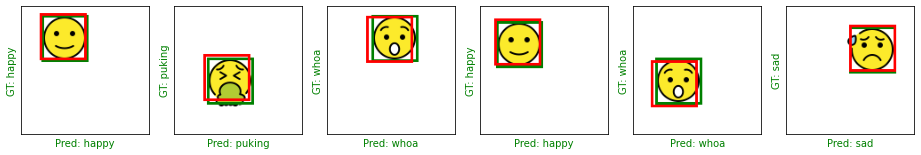

500/500 [==============================] - 9s 18ms/step - loss: 0.0012 - class_out_loss: 2.2666e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7021 - lr: 3.0000e-07
Epoch 40/50
1/1 [==============================] - 0s 22ms/step


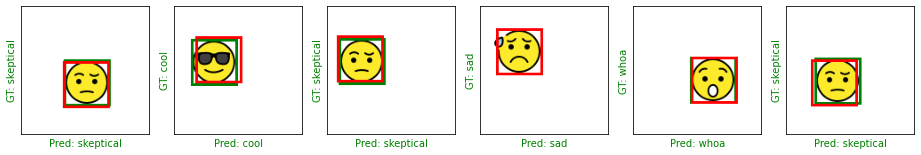

500/500 [==============================] - 9s 18ms/step - loss: 0.0014 - class_out_loss: 3.6294e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7038 - lr: 3.0000e-07
Epoch 41/50
1/1 [==============================] - 0s 21ms/step


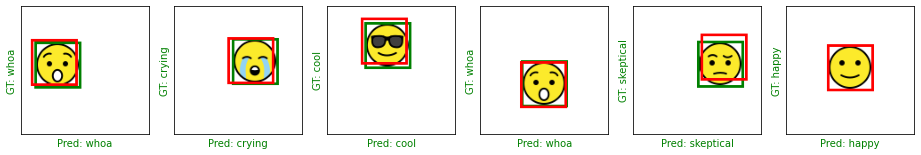

500/500 [==============================] - 9s 18ms/step - loss: 0.0013 - class_out_loss: 2.7198e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7054 - lr: 3.0000e-07
Epoch 42/50
1/1 [==============================] - 0s 21ms/step


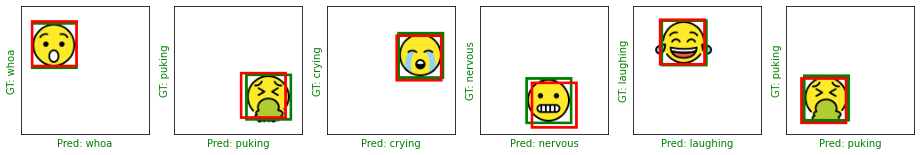

500/500 [==============================] - 9s 19ms/step - loss: 0.0013 - class_out_loss: 2.9122e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7069 - lr: 3.0000e-07
Epoch 43/50
1/1 [==============================] - 0s 22ms/step


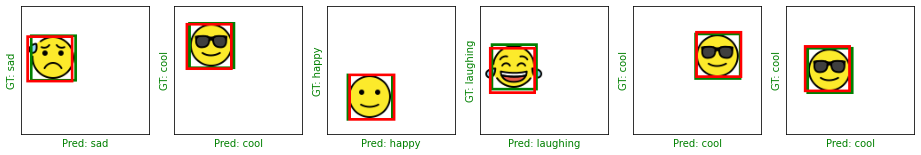

500/500 [==============================] - 9s 18ms/step - loss: 0.0013 - class_out_loss: 2.8120e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7083 - lr: 3.0000e-07
Epoch 44/50
1/1 [==============================] - 0s 21ms/step


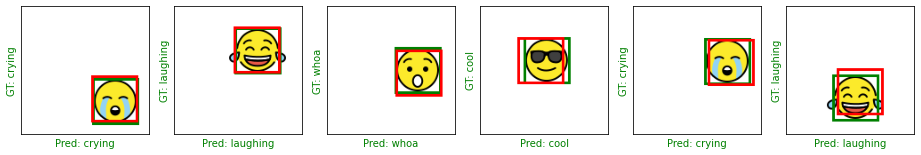

500/500 [==============================] - 9s 18ms/step - loss: 0.0013 - class_out_loss: 2.4367e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7097 - lr: 3.0000e-07
Epoch 45/50
1/1 [==============================] - 0s 20ms/step


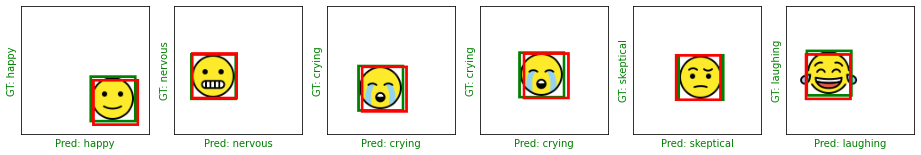

500/500 [==============================] - 9s 18ms/step - loss: 0.0012 - class_out_loss: 2.2659e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7111 - lr: 3.0000e-07
Epoch 46/50
1/1 [==============================] - 0s 26ms/step


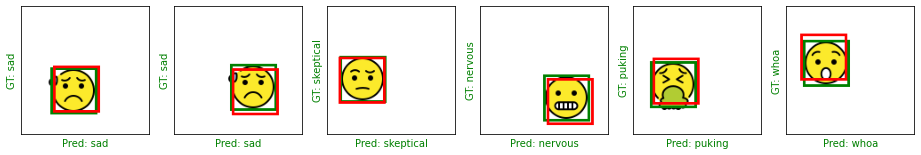

500/500 [==============================] - 9s 18ms/step - loss: 0.0012 - class_out_loss: 2.3816e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7125 - lr: 3.0000e-07
Epoch 47/50
1/1 [==============================] - 0s 22ms/step


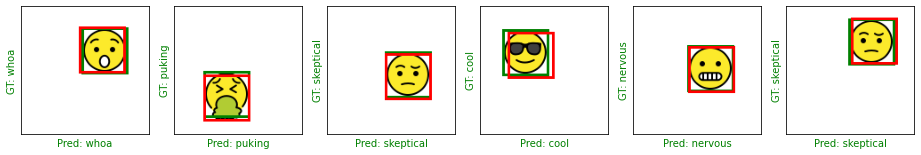

500/500 [==============================] - 9s 18ms/step - loss: 0.0013 - class_out_loss: 2.3174e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7137 - lr: 3.0000e-07
Epoch 48/50
1/1 [==============================] - 0s 22ms/step


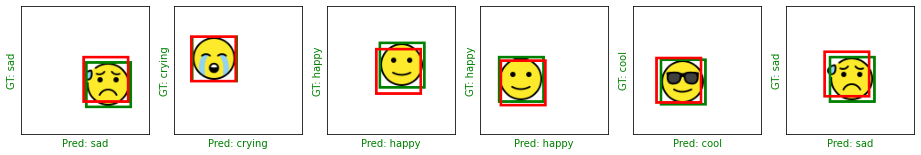

500/500 [==============================] - 9s 18ms/step - loss: 0.0012 - class_out_loss: 2.4112e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7149 - lr: 3.0000e-07
Epoch 49/50
1/1 [==============================] - 0s 21ms/step


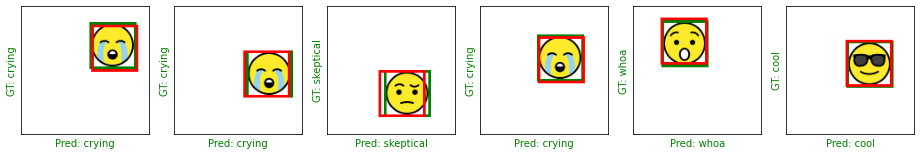

500/500 [==============================] - 9s 18ms/step - loss: 0.0014 - class_out_loss: 3.4817e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7160 - lr: 3.0000e-07
Epoch 50/50
1/1 [==============================] - 0s 24ms/step


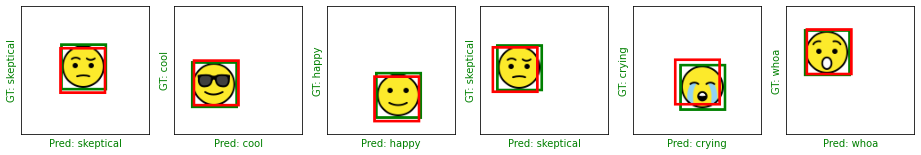

500/500 [==============================] - 10s 19ms/step - loss: 0.0013 - class_out_loss: 2.6070e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7171 - lr: 3.0000e-07


In [20]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 5 == 0:
        lr *= 0.2
    return max(lr, 3e-7)


_ = model.fit(
    data_generator(),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
               ShowTestImages(),
               tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'),
               tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)